# **Group - 21**

1) Raghav Bhalla (2019379)

2) Ritesh Panwar (2019384) 

**RESNET50 Deep CNN model**

In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.cluster import KMeans
import configparser
import numpy as np
import cv2
import os
import pickle
import shutil
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import random
from urllib.parse import urlparse
from scipy.spatial.distance import cityblock
import cv2

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from pathlib import Path
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
images_file_path = '/content/drive/MyDrive/data/images_array'
with open(images_file_path, 'rb') as f:
    images_Arr = pickle.load(f)

In [4]:
image_train = images_Arr[:7500]
image_test = images_Arr[7500:]

In [5]:
train_inp = []

for i in range(0, len(image_train)):
  # Resizing the image for VGG16 model architecture, and also converting the color space of image
  img_temp= image_train[i].resize((100, 100))
  img_temp = img_temp.convert('RGB')
  train_inp.append(np.array(img_temp))

In [6]:
test_inp = []

for i in range(0, len(image_test)):
  # Resizing the image for VGG16 model architecture, and also converting the color space of image
  img_temp = image_test[i].resize((100, 100))
  img_temp = img_temp.convert('RGB')
  test_inp.append(np.array(img_temp))

In [7]:
train_inp[1].shape

(100, 100, 3)

In [8]:
h = 100
w = 100
nc = 3
IN = Input(shape = (h,w,nc))
model = ResNet50(include_top = False, weights='imagenet', input_tensor=IN)
model = Model(inputs = model.input, outputs = model.get_layer('conv5_block3_2_relu').output)

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
images_train_curr = image_train[3].resize((100, 100))
img = image.img_to_array(images_train_curr)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
img.shape
feature = model.predict(img)[0]
print(feature.shape)
feature = feature.flatten()
print(feature.shape)

(4, 4, 512)
(8192,)


Only run if features not extracted

In [ ]:
features_Arr = []

#Iterating over each image in database to obtain features
for i in range(0, len(image_train)):

  # Resizing the image for VGG16 model architecture, and also converting the color space of image
  images_train_curr = image_train[i].resize((100, 100))
  # print(type(images_train_curr))
  # images_train_curr = np.resize(images_train[i], (224, 224))
  # print(type(images_train_curr))
  images_train_curr = images_train_curr.convert('RGB')

  # Reformat and preprocessing the image
  img = image.img_to_array(images_train_curr)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  # Extracting features of current index image
  feature = model.predict(img)[0]
  feature_norm = np.linalg.norm(feature)
  feature /= feature_norm

  # Appeding the features of current index image in features array
  features_Arr.append(feature.flatten())


feature_path = "features.npy"
np.save(feature_path, features_Arr)

#For saving in Gdrive
feature_path = "/content/drive/My Drive/Images_ML/features_RESNET50.npy"
np.save(feature_path, features_Arr)

In [ ]:
# features_Arr

In [10]:
def plot_images(num_images, similar_images):

  #Displaying Similar Images with the distance metric
  axes=[]
  figure = plt.figure(figsize=(18,14), edgecolor='black')

  for i in range(num_images):
      axes.append(figure.add_subplot(4, 5, i+1))
      rank = 'Rank-' + str(i+1)
      axes[-1].set_title(rank + '\nScore: '+ str(similar_images[i][0]))  
      plt.imshow(similar_images[i][1])
      plt.axis('off')
      # display(similar_images[i][1])
  
  figure.tight_layout()
  plt.show()

In [11]:
#Euclidean distance between features of each image in database with the query image
def euclidian_dist(features, query_feature):
  euclidean_dists = np.linalg.norm(features - query_feature, axis=1)
  return euclidean_dists

#Cosine Similarity between features of each image in database with the query image
def cosine_similarity(features, query_feature):
  cosine_similarity_scores = features.dot(query_feature) / (np.linalg.norm(features, axis=1) * np.linalg.norm(query_feature))
  return cosine_similarity_scores

#Manhattan distance between features of each image in database with the query image
def manhattan_dist(features, query_feature):
  manhattan_dists = []
  for i in range(len(features)):
    manhattan_dists.append(cityblock(features[i], query_feature))
  return np.array(manhattan_dists)

In [12]:
def predict_similar_images(index, num_images, eval_metric):

  #Displaying query Image first
  print("Query Image :")
  query_img = image_test[index]
  display(query_img)
  print('--------------------------------\n')

  #extracting features of query file
  # Resizing the image for VGG16 model architecture, and also converting the color space of image
  query_img = query_img.resize((100, 100))
  query_img = query_img.convert('RGB')

  # Reformat and preprocessing the image
  img = image.img_to_array(query_img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  # Extracting features of current index image
  query_feature = model.predict(img)[0]
  query_feature = query_feature.flatten()
  query_feature_norm = np.linalg.norm(query_feature)
  query_feature /= query_feature_norm

  features_file_path = "/content/drive/My Drive/data/features_RESNET50.npy"
  features = np.load(features_file_path)

  #Computing similarity/distances between query image and all images based on extracted features
  #Also sorting resultant metrics to get top k similar images
  if eval_metric == 'cosine':
    metric = cosine_similarity(features, query_feature)
    similar_images_index = np.flip(np.argsort(metric))[:num_images]
  elif eval_metric == 'manhattan':
    metric = manhattan_dist(features, query_feature)
    similar_images_index = np.argsort(metric)[:num_images]
  else:
    metric = euclidian_dist(features, query_feature)
    similar_images_index = np.argsort(metric)[:num_images]

  similar_images = []
  for i in similar_images_index:
    similar_images.append((round(metric[i],5), image_train[i]))

  #Displaying Similar Images with the distance metric
  print('Similar Images')
  plot_images(num_images, similar_images)


Enter Input Index: 200
Enter Number of Similar Images to be predicted (Upto 20): 5


------------------------------------------------------------------------
	 SIMILAR IMAGES BASED ON MANHATTAN DISTANCE
------------------------------------------------------------------------
Query Image :


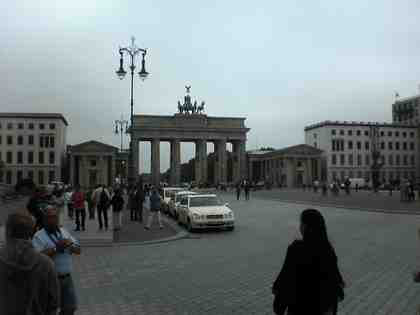

--------------------------------

Similar Images


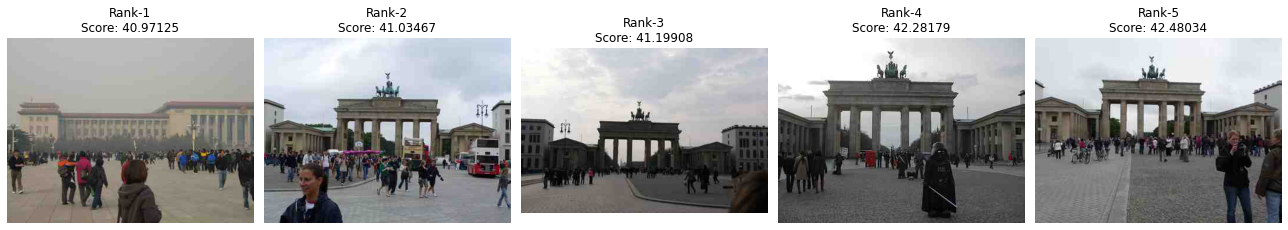



------------------------------------------------------------------------
	 SIMILAR IMAGES BASED ON EUCLIDEAN DISTANCE
------------------------------------------------------------------------
Query Image :


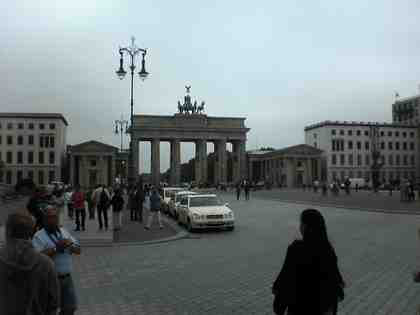

--------------------------------

Similar Images


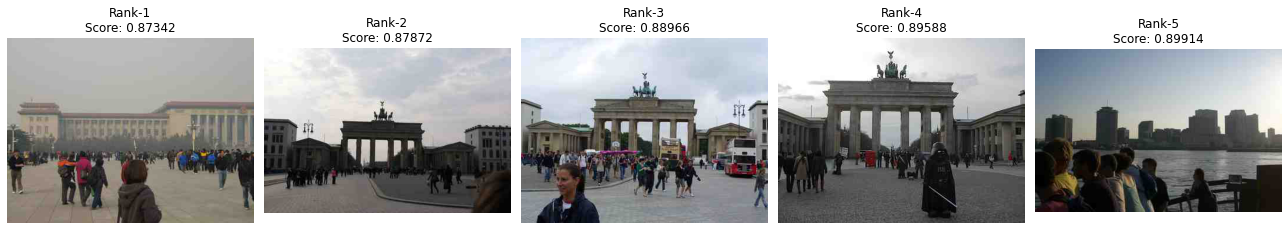



------------------------------------------------------------------------
	 SIMILAR IMAGES BASED ON COSINE SIMILARITY
------------------------------------------------------------------------
Query Image :


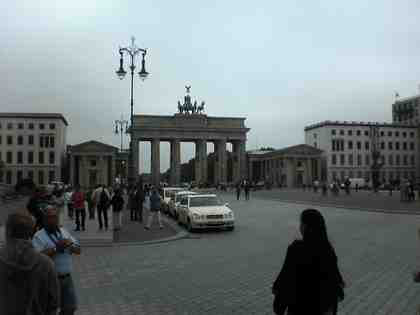

--------------------------------

Similar Images


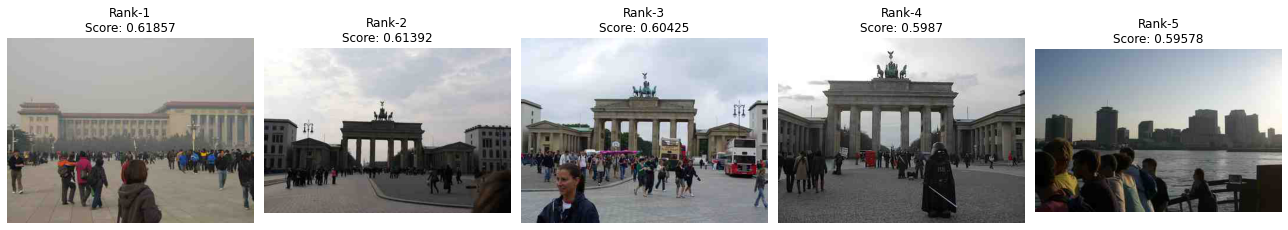

In [13]:
index = int(input("Enter Input Index: "))
num_images = int(input("Enter Number of Similar Images to be predicted (Upto 20): "))

print('\n')
print('------------------------------------------------------------------------')
print('\033[1m' + '\t SIMILAR IMAGES BASED ON MANHATTAN DISTANCE' + '\033[0m')
print('------------------------------------------------------------------------')
predict_similar_images(index, num_images, 'manhattan')

print('\n')
print('------------------------------------------------------------------------')
print('\033[1m' + '\t SIMILAR IMAGES BASED ON EUCLIDEAN DISTANCE' + '\033[0m')
print('------------------------------------------------------------------------')
predict_similar_images(index, num_images, 'euclidean')

print('\n')
print('------------------------------------------------------------------------')
print('\033[1m' + '\t SIMILAR IMAGES BASED ON COSINE SIMILARITY' + '\033[0m')
print('------------------------------------------------------------------------')
predict_similar_images(index, num_images, 'cosine')